# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [25]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

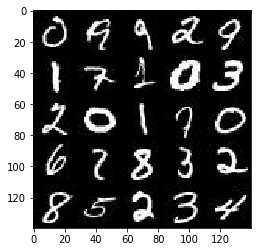

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

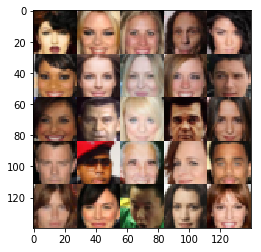

In [27]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [29]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, None, name = 'learning_rate')
    
    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', 
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        conv4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.05))
        bn4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
                
        flat = tf.contrib.layers.flatten(relu4)
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)        

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):        
        x1 = tf.layers.dense(z, 7*7*512)
                
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    variables = tf.trainable_variables()
    d_vars = [variable for variable in variables if variable.name.startswith('discriminator')]
    g_vars = [variable for variable in variables if variable.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):        
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    
    samples, losses = [], []
    steps = 0
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
           
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})                
                
                if steps % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.8720
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 1.9939
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 1.8219
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.8944


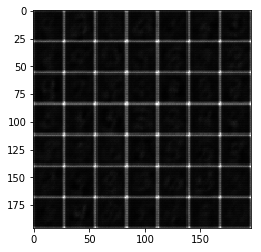

Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 1.3234
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.7841


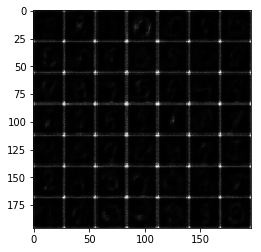

Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.3504
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 1.8119
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.5621
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 0.8105


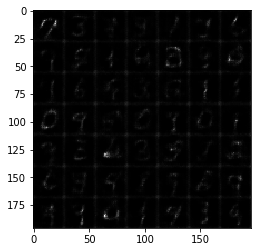

Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 1.4848
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 1.2889


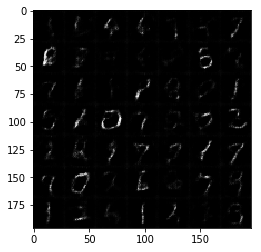

Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 1.5178
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.3241


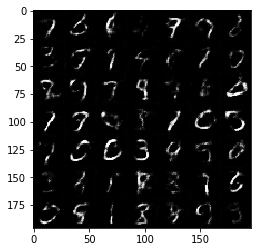

Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.0897
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 1.7282
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.8529


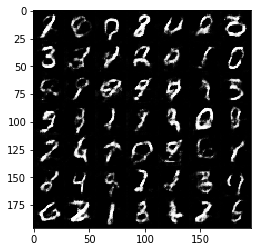

Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.8052
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.1499... Generator Loss: 1.4346
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.1607
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.4087


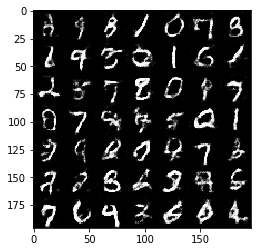

Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 1.4319
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 1.6067
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 1.3759
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.5286
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 1.0075
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 1.4137
Epoch 2/2... Discriminator Loss: 1.0714... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.4030


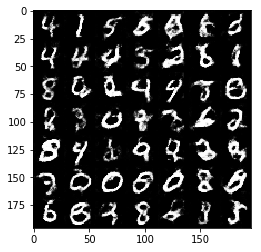

Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 0.9951
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.1557
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.3267


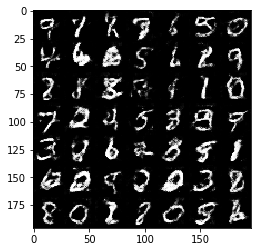

Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.1278... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 1.3590


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 6.9646
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 7.0419
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 10.9462
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 3.8525
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 4.4763
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.4823


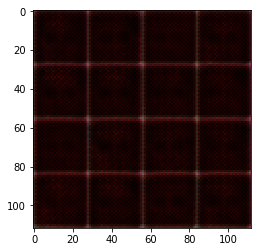

Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.9898
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 2.0082... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.7321... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.2775
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6343


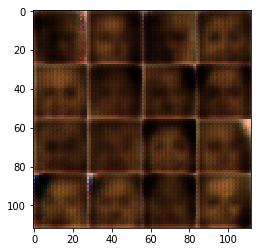

Epoch 1/1... Discriminator Loss: 2.0272... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.7680... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.8490
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.2923


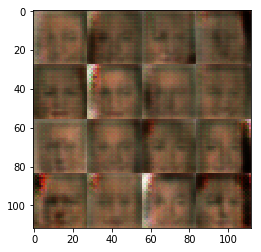

Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8419


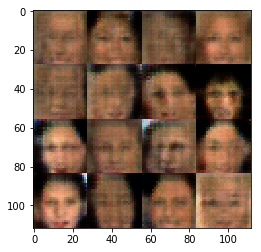

Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.5506
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.7592
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8826


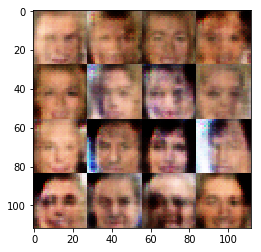

Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.7677
Epoch 1/1... Discriminator Loss: 2.2710... Generator Loss: 0.1735
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 1.8556


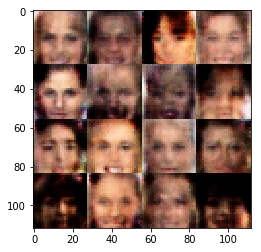

Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 2.3503
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.7197
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 1.6492


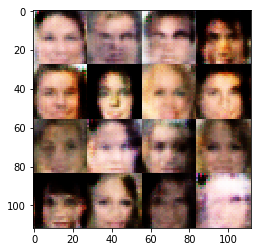

Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.9916... Generator Loss: 0.2301
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 2.0618... Generator Loss: 0.2450
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6976


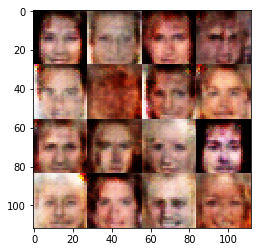

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 1.0607... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.3354
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 1.7406


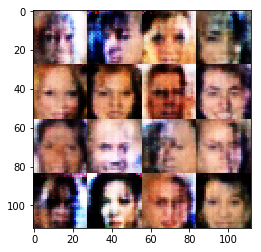

Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 2.5121... Generator Loss: 3.4713
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.1334


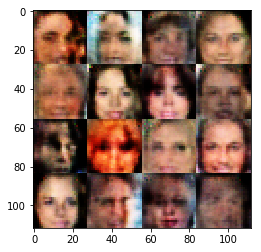

Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 2.4945
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 2.0025
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.3900
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 1.0200


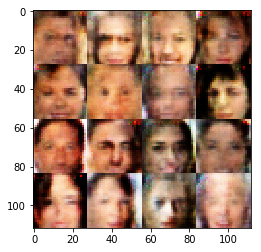

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 2.1199


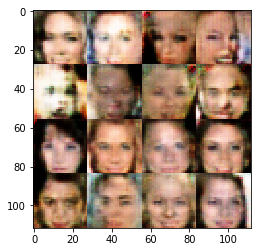

Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.4240
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.1336


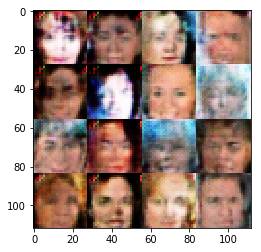

Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.5515
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 2.4560... Generator Loss: 0.1783
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.4310


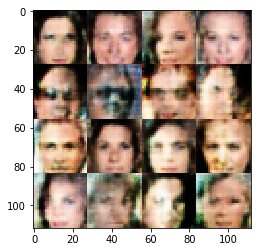

Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.4261
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.7794
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.5576


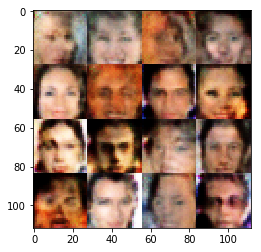

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.8764
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.7885... Generator Loss: 2.2991
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.6944... Generator Loss: 2.2192
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.9261


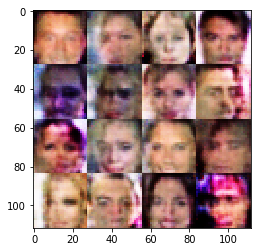

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 2.3864
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 1.8439
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 2.0082
Epoch 1/1... Discriminator Loss: 1.8808... Generator Loss: 0.2790


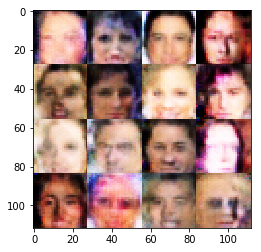

Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.6801
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.2489
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 3.1839
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0171


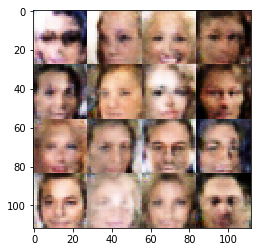

Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 2.1235
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.4196


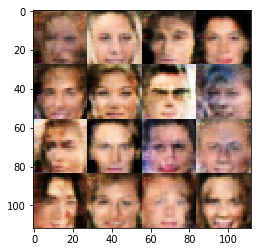

Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 1.8406
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7275


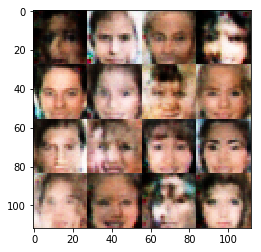

Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.8749... Generator Loss: 0.2738
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.3467
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 1.6871


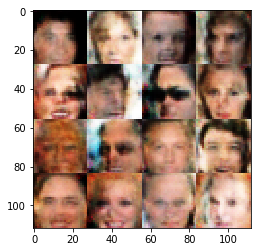

Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.5685
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.7243


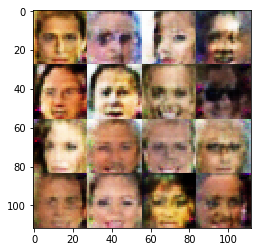

Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 2.2664... Generator Loss: 3.0105
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.5171
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7390


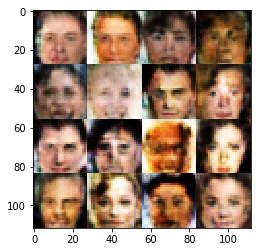

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 2.4495
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.3933


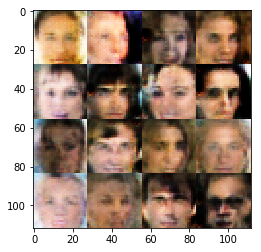

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.8202
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.3742
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.8702


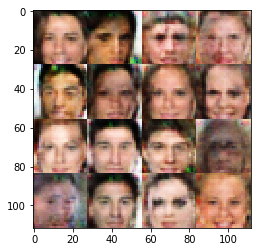

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.5880
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 2.7990
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4342


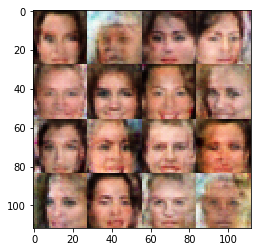

Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 2.0628... Generator Loss: 0.2325
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.0684


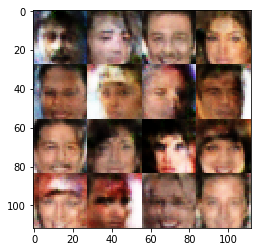

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.4199
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.7369


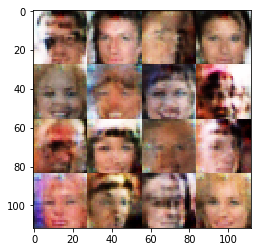

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.7855... Generator Loss: 0.3111
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7805


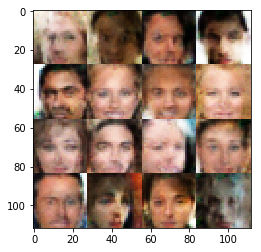

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 2.0494
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 2.0445


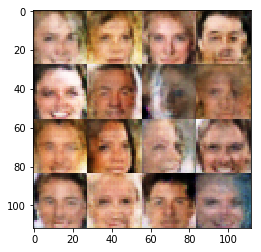

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.9164


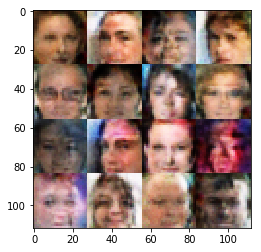

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7444


In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.